# DMRG solution

For this task we will be constructing an DMRG-based solution to the UDMIS problem. This we will effectively be another classical approach, but using tools from tensor networks and condensed matter physics.

Firstly, we construct a matrix product operator of the Hamiltonian
$$
H = -\sum_{i\in V} \hat n_i + u \sum_{(i,j)\in E}\hat n_i \hat n_j
$$
by re-expressing it as a Pauli Hamiltonian. *(This isn't necessary but we are reusing some of our code for generating local Pauli Hamilonians)*

We instead have
$$
H = -\sum_{i\in V}\frac12 (I-Z_i) + u \sum_{(i,j)\in E} \frac{u}{4} (I - Z_I - Z_j + Z_i Z_j)
$$
Once we have the Hamiltonian in the form of an MPO we can use DMRG to find the ground state (an MPS) which will be the solution to our problem. This will allow us to scale this approach to higher dimensions (larger graphs) without hitting intractable demands on memory.

First, lets use the DMRG solution for the previous task to be sure it does what we expect.

In [1]:
from src.local import *
from src.udmis import *

import matplotlib.pyplot as plt

In [2]:
u = 1.35
graph = [
    (0.3461717838632017, 1.4984640297338632),
    (0.6316400411846113, 2.5754677320579895),
    (1.3906262250927481, 2.164978861396621),
    (0.66436005100802, 0.6717919819739032),
    (0.8663329771713457, 3.3876341010035995),
    (1.1643107343501296, 1.0823066243402013)
]

In [3]:
udmis = MPOClassicalUDMIS(u, graph)
udmis.hamiltonian

Local Hamiltonian Object:
Nsites:		6
Locality:	6

See now, with no pre-ordering on our graph we end up with some high weight non-local terms (up weight 6) in the Hamiltonian. This is simply due to the defined sites of each node being poorly chosen. Let's do a simple heuristic sort on their distance from the coordinate `(0,0)`

In [4]:
locality = []
for ci in udmis.hamiltonian.c:
    locality.append(len(ci[1]))

In [5]:
# Let's do a simple heuristic sort these nodes to give something more local
graph = sorted(graph, key=lambda g: np.linalg.norm(g))

In [6]:
udmis = MPOClassicalUDMIS(u, graph)
udmis.hamiltonian

Local Hamiltonian Object:
Nsites:		6
Locality:	3

Now we have a max weight of `3` in the Hamiltonian, which will significantly reduce the bond-dimension of the MPO

In [7]:
locality_opt = []
for ci in udmis.hamiltonian.c:
    locality_opt.append(len(ci[1]))

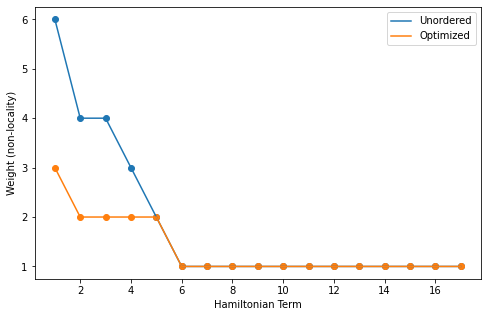

In [8]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,len(locality)+1), sorted(locality, reverse=True), label="Unordered")
ax.scatter(range(1,len(locality)+1), sorted(locality, reverse=True))
ax.plot(range(1,len(locality)+1), sorted(locality_opt, reverse=True), label="Optimized")
ax.scatter(range(1,len(locality)+1), sorted(locality_opt, reverse=True))
ax.set_xlabel("Hamiltonian Term")
ax.set_ylabel("Weight (non-locality)")
ax.legend()
plt.show()

In [9]:
H = udmis.hamiltonian
H

Local Hamiltonian Object:
Nsites:		6
Locality:	3

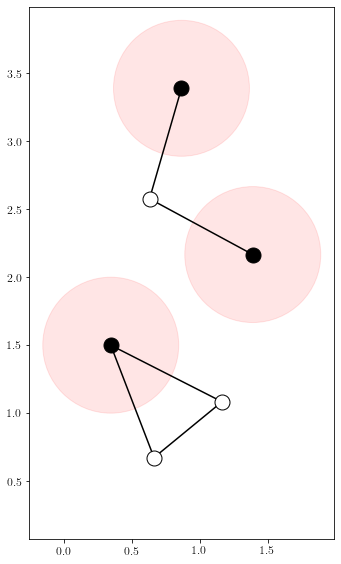

In [10]:
from src.figures import *

fig,ax = plt.subplots(figsize=(12, 8))
plot_mpo_udmis(ax, udmis)
plt.tight_layout()

# Gotham City

Shown below is the cell-tower array in Gotham City. We need to find the UDMIS solution to determine the max independent set of towers that we can turn on without them overlapping.

In [11]:
graph = [(1.19, 4.25),
         (2.71, 3.48),
         (1.19, 3.51),
         (2, 3.38),
         (1.12, 2.86),
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15, 1.54),
         (2.14, 1.87),
         (1.72, 0.86),
         (2.29, 0.87)]

In [12]:
# Let's do a simple heuristic sort these nodes to give something more local again
graph = sorted(graph, key=lambda g: np.linalg.norm(g))
udmis = MPOClassicalUDMIS(u, graph)
udmis.hamiltonian

Local Hamiltonian Object:
Nsites:		12
Locality:	5

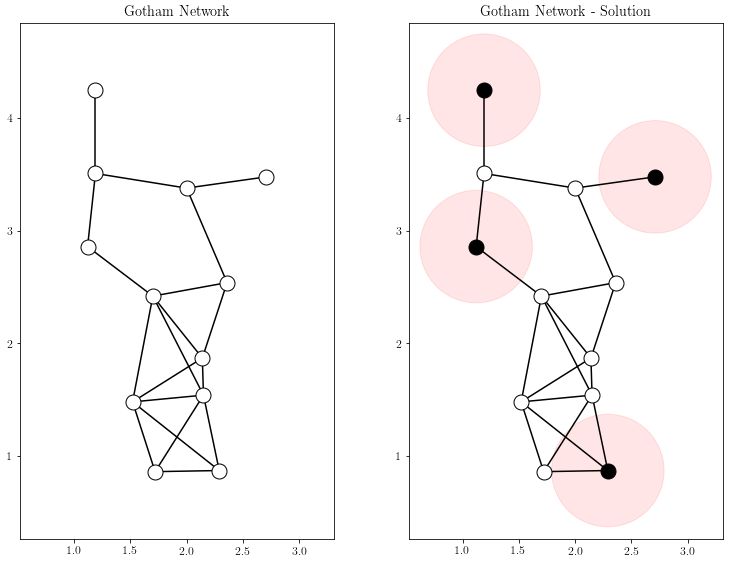

In [14]:
from src.figures import *

fig,axs= plt.subplots(1,2, figsize=(12, 8))
ax = axs[0]
plot_mpo_initial(ax, udmis)
ax.set_title("Gotham Network")

ax = axs[1]
plot_mpo_udmis(ax, udmis)
ax.set_title("Gotham Network - Solution")

plt.savefig('../fig/gotham.pdf')

Remarkably, only 4 towers can be on without having some overlap of their range!